# Predicting length of stay

## Import Libraries

Please install necessary packages before proceeding

In [109]:
# !pip install xgboost

# !pip install lightgbm

# !pip install catboost

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import psutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score, f1_score, log_loss
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import customfunctions as fn
import encoding as enc
import Featureimportance as fi
import modeling as md
import tuning as tn
import warnings
import importlib
# Display all rows and columns in DataFrame outputs
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Optional: Increase column width and display precision for better readability
pd.set_option('display.width', 1000)  # Set the display width
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.float_format', '{:.4f}'.format)
seed=42

In [15]:
os.chdir('../Data')

In [16]:
os.listdir()

['catboost_info',
 'test_data.csv',
 'train_data.csv',
 'train_data_dictionary.csv']

## Load Dataset

In [17]:
df_Train=pd.read_csv('train_data.csv')
df_Test = pd.read_csv('test_data.csv')
df_description = pd.read_csv('train_data_dictionary.csv')

## Describe the Dataset

In [18]:
df_description

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


In [19]:
df_Train.columns = (
    df_Train.columns
    .str.strip()  # Remove leading/trailing spaces
    .str.lower()  # Convert to lowercase
    .str.replace(" ", "_")  # Replace spaces with underscores
    .str.replace("[^a-z0-9_]", "", regex=True)  # Remove non-alphanumeric characters
)

In [20]:
df_Test.columns = (
    df_Test.columns
    .str.strip()  # Remove leading/trailing spaces
    .str.lower()  # Convert to lowercase
    .str.replace(" ", "_")  # Replace spaces with underscores
    .str.replace("[^a-z0-9_]", "", regex=True)  # Remove non-alphanumeric characters
)

converting the feature names into lower case and replacing spaces with underscore

In [21]:
df_description.iloc[:, 0] = df_description.iloc[:, 0].str.lower().str.replace(" ", "_")

In [22]:
df_Train.head()

,case_id,hospital_code,hospital_type_code,city_code_hospital,hospital_region_code,available_extra_rooms_in_hospital,department,ward_type,ward_facility_code,bed_grade,patientid,city_code_patient,type_of_admission,severity_of_illness,visitors_with_patient,age,admission_deposit,stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0000,31397,7.0000,Emergency,Extreme,2,51-60,4911.0000,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0000,31397,7.0000,Trauma,Extreme,2,51-60,5954.0000,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0000,31397,7.0000,Trauma,Extreme,2,51-60,4745.0000,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0000,31397,7.0000,Trauma,Extreme,2,51-60,7272.0000,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0000,31397,7.0000,Trauma,Extreme,2,51-60,5558.0000,41-50


In [23]:
df_Test.head()

,case_id,hospital_code,hospital_type_code,city_code_hospital,hospital_region_code,available_extra_rooms_in_hospital,department,ward_type,ward_facility_code,bed_grade,patientid,city_code_patient,type_of_admission,severity_of_illness,visitors_with_patient,age,admission_deposit
0,318439,21,c,3,Z,3,gynecology,S,A,2.0000,17006,2.0000,Emergency,Moderate,2,71-80,3095.0000
1,318440,29,a,4,X,2,gynecology,S,F,2.0000,17006,2.0000,Trauma,Moderate,4,71-80,4018.0000
2,318441,26,b,2,Y,3,gynecology,Q,D,4.0000,17006,2.0000,Emergency,Moderate,3,71-80,4492.0000
3,318442,6,a,6,X,3,gynecology,Q,F,2.0000,17006,2.0000,Trauma,Moderate,3,71-80,4173.0000
4,318443,28,b,11,X,2,gynecology,R,F,2.0000,17006,2.0000,Trauma,Moderate,4,71-80,4161.0000


In [24]:
print("The Train dataframe has {} rows and {} columns".format(df_Train.shape[0],df_Train.shape[1]))
print("The data types of each column of the dataframe are:")
print(df_Train.info())

The Train dataframe has 318438 rows and 18 columns
The data types of each column of the dataframe are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   hospital_code                      318438 non-null  int64  
 2   hospital_type_code                 318438 non-null  object 
 3   city_code_hospital                 318438 non-null  int64  
 4   hospital_region_code               318438 non-null  object 
 5   available_extra_rooms_in_hospital  318438 non-null  int64  
 6   department                         318438 non-null  object 
 7   ward_type                          318438 non-null  object 
 8   ward_facility_code                 318438 non-null  object 
 9   bed_grade                          318325 non-null  float64
 10  p

In [25]:
print("The Test dataframe has {} rows and {} columns".format(df_Test.shape[0],df_Test.shape[1]))
print("The data types of each column of the dataframe are:")
print(df_Test.info())

The Test dataframe has 137057 rows and 17 columns
The data types of each column of the dataframe are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137057 entries, 0 to 137056
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            137057 non-null  int64  
 1   hospital_code                      137057 non-null  int64  
 2   hospital_type_code                 137057 non-null  object 
 3   city_code_hospital                 137057 non-null  int64  
 4   hospital_region_code               137057 non-null  object 
 5   available_extra_rooms_in_hospital  137057 non-null  int64  
 6   department                         137057 non-null  object 
 7   ward_type                          137057 non-null  object 
 8   ward_facility_code                 137057 non-null  object 
 9   bed_grade                          137022 non-null  float64
 10  pa

In [26]:
df_Train.isnull().sum()

case_id                                 0
hospital_code                           0
hospital_type_code                      0
city_code_hospital                      0
hospital_region_code                    0
available_extra_rooms_in_hospital       0
department                              0
ward_type                               0
ward_facility_code                      0
bed_grade                             113
patientid                               0
city_code_patient                    4532
type_of_admission                       0
severity_of_illness                     0
visitors_with_patient                   0
age                                     0
admission_deposit                       0
stay                                    0
dtype: int64

In [27]:
df_Test.isnull().sum()

case_id                                 0
hospital_code                           0
hospital_type_code                      0
city_code_hospital                      0
hospital_region_code                    0
available_extra_rooms_in_hospital       0
department                              0
ward_type                               0
ward_facility_code                      0
bed_grade                              35
patientid                               0
city_code_patient                    2157
type_of_admission                       0
severity_of_illness                     0
visitors_with_patient                   0
age                                     0
admission_deposit                       0
dtype: int64

In [28]:
importlib.reload(fn)

NameError: name 'importlib' is not defined

In [125]:
df_Train.columns

Index(['case_id', 'hospital_code', 'hospital_type_code', 'city_code_hospital', 'hospital_region_code', 'available_extra_rooms_in_hospital', 'department', 'ward_type', 'ward_facility_code', 'bed_grade', 'patientid', 'city_code_patient', 'type_of_admission', 'severity_of_illness', 'visitors_with_patient', 'age', 'admission_deposit', 'stay'], dtype='object')

In [126]:
fn.process_data(df_Train)

Converted the following columns to categorical: ['hospital_code', 'city_code_hospital', 'bed_grade', 'city_code_patient']
Dropped the 'case_id' and 'patientid' columns as they are unique identifiers and not useful for modeling.
Processed DataFrame shape: (318438, 16)
Data types after processing:
hospital_code                        category
hospital_type_code                     object
city_code_hospital                   category
hospital_region_code                   object
available_extra_rooms_in_hospital       int64
department                             object
ward_type                              object
ward_facility_code                     object
bed_grade                            category
city_code_patient                    category
type_of_admission                      object
severity_of_illness                    object
visitors_with_patient                   int64
age                                    object
admission_deposit                     float64
stay         

In [29]:
fn.process_data(df_Test)

Converted the following columns to categorical: ['hospital_code', 'city_code_hospital', 'bed_grade', 'city_code_patient']
Dropped the 'case_id' and 'patientid' columns as they are unique identifiers and not useful for modeling.
Processed DataFrame shape: (137057, 15)
Data types after processing:
hospital_code                        category
hospital_type_code                     object
city_code_hospital                   category
hospital_region_code                   object
available_extra_rooms_in_hospital       int64
department                             object
ward_type                              object
ward_facility_code                     object
bed_grade                            category
city_code_patient                    category
type_of_admission                      object
severity_of_illness                    object
visitors_with_patient                   int64
age                                    object
admission_deposit                     float64
dtype: object

In [30]:
fn.summarize_nulls_and_modalities(df_Train,df_Train.columns)

,Column Name,Null Count,Null Percentage,Modalities,Data Type
0,city_code_patient,4532,1.4232,37,float64
1,bed_grade,113,0.0355,4,float64


In [31]:
fn.summarize_nulls_and_modalities(df_Test,df_Test.columns)

,Column Name,Null Count,Null Percentage,Modalities,Data Type
0,city_code_patient,2157,1.5738,37,category
1,bed_grade,35,0.0255,4,category


In [32]:
fn.get_descriptions_for_variables(df_description,["City_Code_Patient","Bed Grade"])

,Column,Description


In [33]:
categorical_features = df_Train.select_dtypes(include=['object','category']).columns
numerical_features = df_Train.select_dtypes(exclude=['object','category']).columns

In [34]:
categorical_features

Index(['hospital_type_code', 'hospital_region_code', 'department', 'ward_type', 'ward_facility_code', 'type_of_admission', 'severity_of_illness', 'age', 'stay'], dtype='object')

In [35]:
df_Train[categorical_features].nunique()

hospital_type_code       7
hospital_region_code     3
department               5
ward_type                6
ward_facility_code       6
type_of_admission        3
severity_of_illness      3
age                     10
stay                    11
dtype: int64

In [36]:
numerical_features

Index(['case_id', 'hospital_code', 'city_code_hospital', 'available_extra_rooms_in_hospital', 'bed_grade', 'patientid', 'city_code_patient', 'visitors_with_patient', 'admission_deposit'], dtype='object')

In [37]:
print(f'Number of numerical features: {len(numerical_features)}')
print(f'Number of categorical features: {len(categorical_features)}')  

Number of numerical features: 9
Number of categorical features: 9


In [38]:
df_Train[numerical_features].describe()

,case_id,hospital_code,city_code_hospital,available_extra_rooms_in_hospital,bed_grade,patientid,city_code_patient,visitors_with_patient,admission_deposit
count,318438.0000,318438.0000,318438.0000,318438.0000,318325.0000,318438.0000,313906.0000,318438.0000,318438.0000
mean,159219.5000,18.3188,4.7717,3.1976,2.6258,65747.5795,7.2519,3.2841,4880.7494
std,91925.2768,8.6338,3.1025,1.1682,0.8731,37979.9364,4.7453,1.7641,1086.7763
min,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1800.0000
25%,79610.2500,11.0000,2.0000,2.0000,2.0000,32847.0000,4.0000,2.0000,4186.0000
50%,159219.5000,19.0000,5.0000,3.0000,3.0000,65724.5000,8.0000,3.0000,4741.0000
75%,238828.7500,26.0000,7.0000,4.0000,3.0000,98470.0000,8.0000,4.0000,5409.0000
max,318438.0000,32.0000,13.0000,24.0000,4.0000,131624.0000,38.0000,32.0000,11008.0000


In [39]:
df_Train[categorical_features].describe()

,hospital_type_code,hospital_region_code,department,ward_type,ward_facility_code,type_of_admission,severity_of_illness,age,stay
count,318438,318438,318438,318438,318438,318438,318438,318438,318438
unique,7,3,5,6,6,3,3,10,11
top,a,X,gynecology,R,F,Trauma,Moderate,41-50,21-30
freq,143425,133336,249486,127947,112753,152261,175843,63749,87491


## Drop Duplicates and Null Values

Since the percentage of null values is minimal, we can drop the affected rows/columns to maintain data integrity.

In [40]:
print("Train Set\n")
fn.clean_data_inplace(df_Train)
print("\n")
print("Test Set\n")
fn.clean_data_inplace(df_Test)

Train Set

Initial Shape: (318438, 18)
Shape after dropping rows with missing values: (313793, 18)
No duplicates found after dropping rows with missing values.
Final Shape after cleaning (missing values): (313793, 18)


Test Set

Initial Shape: (137057, 15)
Shape after dropping rows with missing values: (134865, 15)
Duplicates found after dropping missing values: 60 rows.
Duplicates dropped: 60 rows removed.
Final Shape after cleaning (missing values and duplicates): (134805, 15)


In [41]:
df_Train.isnull().sum()

case_id                              0
hospital_code                        0
hospital_type_code                   0
city_code_hospital                   0
hospital_region_code                 0
available_extra_rooms_in_hospital    0
department                           0
ward_type                            0
ward_facility_code                   0
bed_grade                            0
patientid                            0
city_code_patient                    0
type_of_admission                    0
severity_of_illness                  0
visitors_with_patient                0
age                                  0
admission_deposit                    0
stay                                 0
dtype: int64

In [42]:
df_Train[numerical_features].describe()

,case_id,hospital_code,city_code_hospital,available_extra_rooms_in_hospital,bed_grade,patientid,city_code_patient,visitors_with_patient,admission_deposit
count,313793.0000,313793.0000,313793.0000,313793.0000,313793.0000,313793.0000,313793.0000,313793.0000,313793.0000
mean,158937.9111,18.3264,4.7782,3.1964,2.6230,65743.0294,7.2524,3.2809,4881.8932
std,91939.5070,8.6336,3.1032,1.1679,0.8726,37978.0832,4.7452,1.7618,1086.2439
min,1.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,1800.0000
25%,79271.0000,11.0000,2.0000,2.0000,2.0000,32833.0000,4.0000,2.0000,4188.0000
50%,158950.0000,19.0000,5.0000,3.0000,3.0000,65735.0000,8.0000,3.0000,4742.0000
75%,238399.0000,26.0000,7.0000,4.0000,3.0000,98472.0000,8.0000,4.0000,5410.0000
max,318438.0000,32.0000,13.0000,24.0000,4.0000,131624.0000,38.0000,32.0000,11008.0000


In [43]:
df_Train[categorical_features].nunique()

hospital_type_code       7
hospital_region_code     3
department               5
ward_type                6
ward_facility_code       6
type_of_admission        3
severity_of_illness      3
age                     10
stay                    11
dtype: int64

In [44]:
fn.get_descriptions_for_variables(df_description,df_Train.columns)

,Column,Description
0,case_id,Case_ID registered in Hospital
1,hospital_code,Unique code for the Hospital
2,hospital_type_code,Unique code for the type of Hospital
3,city_code_hospital,City Code of the Hospital
4,hospital_region_code,Region Code of the Hospital
5,available_extra_rooms_in_hospital,Number of Extra rooms available in the Hospital
6,department,Department overlooking the case
7,ward_type,Code for the Ward type
8,ward_facility_code,Code for the Ward Facility
9,bed_grade,Condition of Bed in the Ward


In [45]:
df_Train.columns

Index(['case_id', 'hospital_code', 'hospital_type_code', 'city_code_hospital', 'hospital_region_code', 'available_extra_rooms_in_hospital', 'department', 'ward_type', 'ward_facility_code', 'bed_grade', 'patientid', 'city_code_patient', 'type_of_admission', 'severity_of_illness', 'visitors_with_patient', 'age', 'admission_deposit', 'stay'], dtype='object')

## Plotting

In [46]:
importlib.reload(fn)

NameError: name 'importlib' is not defined

In [47]:
fn.get_descriptions_for_variables(df_description,categorical_features)

,Column,Description
0,hospital_type_code,Unique code for the type of Hospital
1,hospital_region_code,Region Code of the Hospital
2,department,Department overlooking the case
3,ward_type,Code for the Ward type
4,ward_facility_code,Code for the Ward Facility
5,type_of_admission,Admission Type registered by the Hospital
6,severity_of_illness,Severity of the illness recorded at the time of admission
7,age,Age of the patient
8,stay,Stay Days by the patient


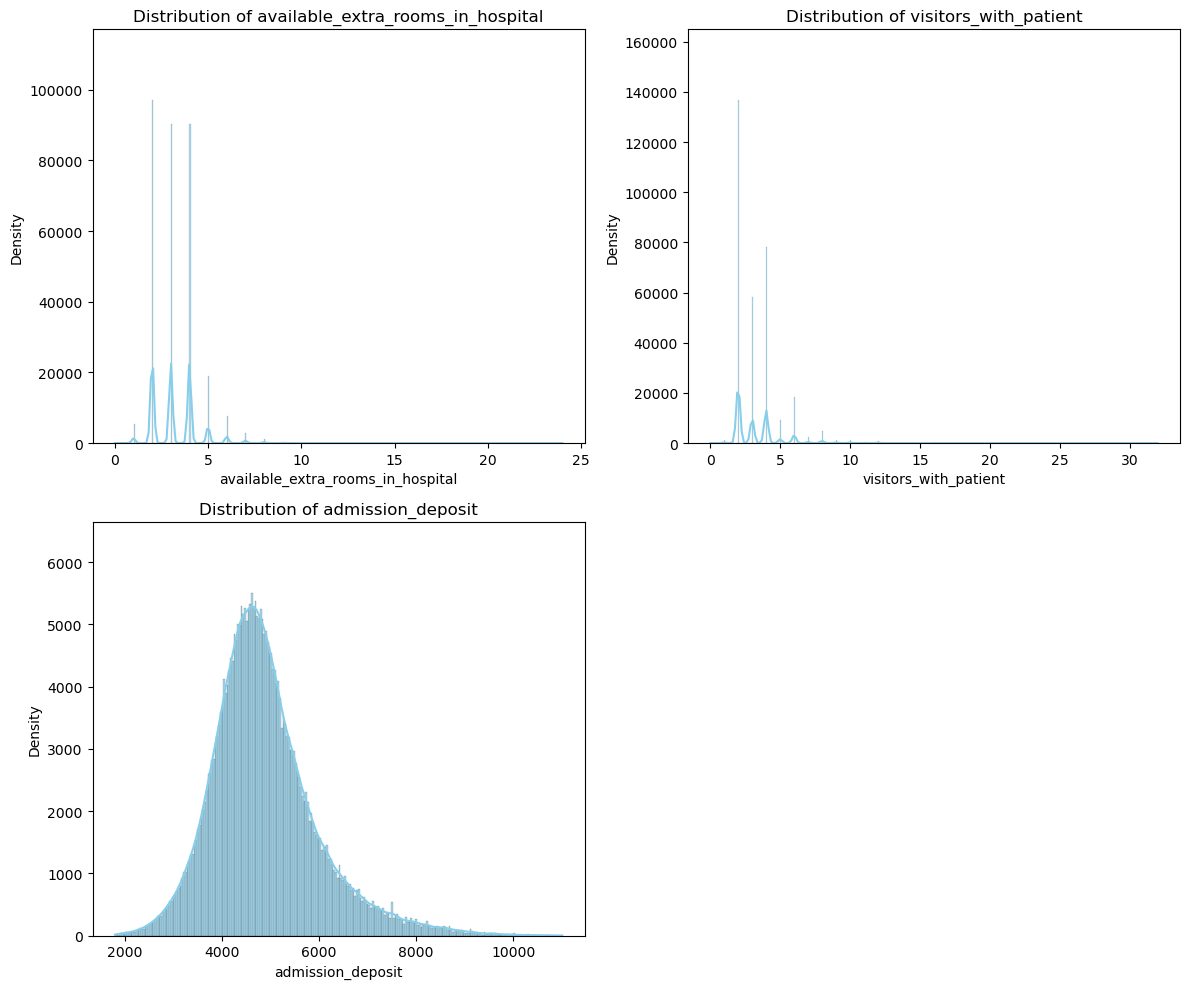

In [146]:
fn.plot_numerical_variables(df_Train,numerical_features)

In [147]:
importlib.reload(fn)

<module 'customfunctions' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\customfunctions.py'>

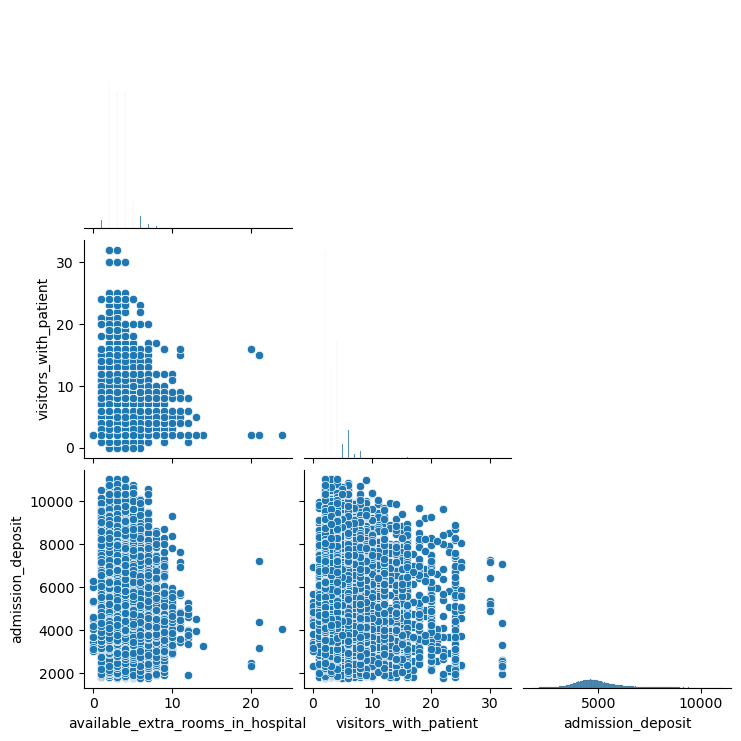

In [148]:
fn.create_pairplot(df_Train[numerical_features])

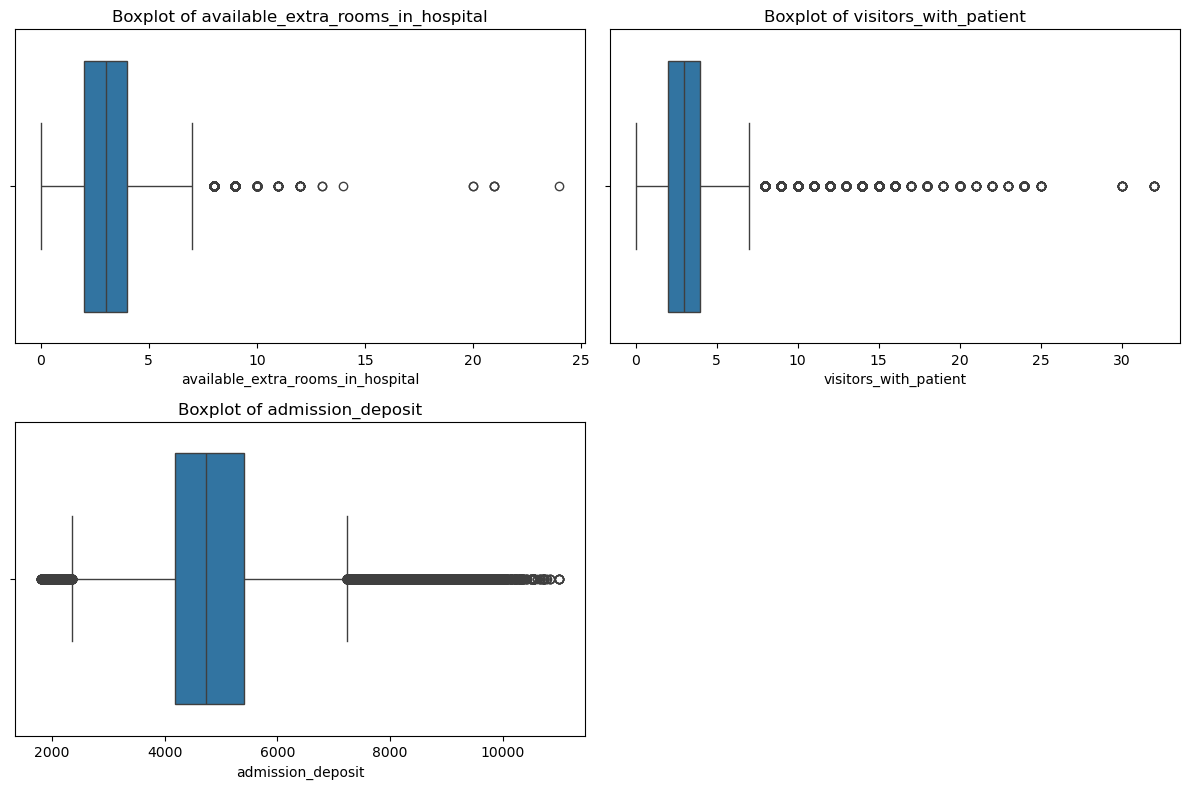

In [149]:
# Create a boxplot for each numerical column
plt.figure(figsize=(12, 8))  # Adjust the figure size if necessary

# Loop through numerical columns and create a boxplot for each
for i, column in enumerate(numerical_features, 1):
    plt.subplot(2, len(numerical_features)//2 + 1, i)  # Adjust the grid size based on the number of columns
    sns.boxplot(data=df_Train, x=column)
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

In [150]:
importlib.reload(fn)

<module 'customfunctions' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\customfunctions.py'>

e:\myprojects\mlprojects\Healthcare - Length of Stay\Code\customfunctions.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=value_counts.index, x=value_counts.values, ax=ax, palette=colors)
e:\myprojects\mlprojects\Healthcare - Length of Stay\Code\customfunctions.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=value_counts.index, x=value_counts.values, ax=ax, palette=colors)
e:\myprojects\mlprojects\Healthcare - Length of Stay\Code\customfunctions.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=value_counts.index, x=value_

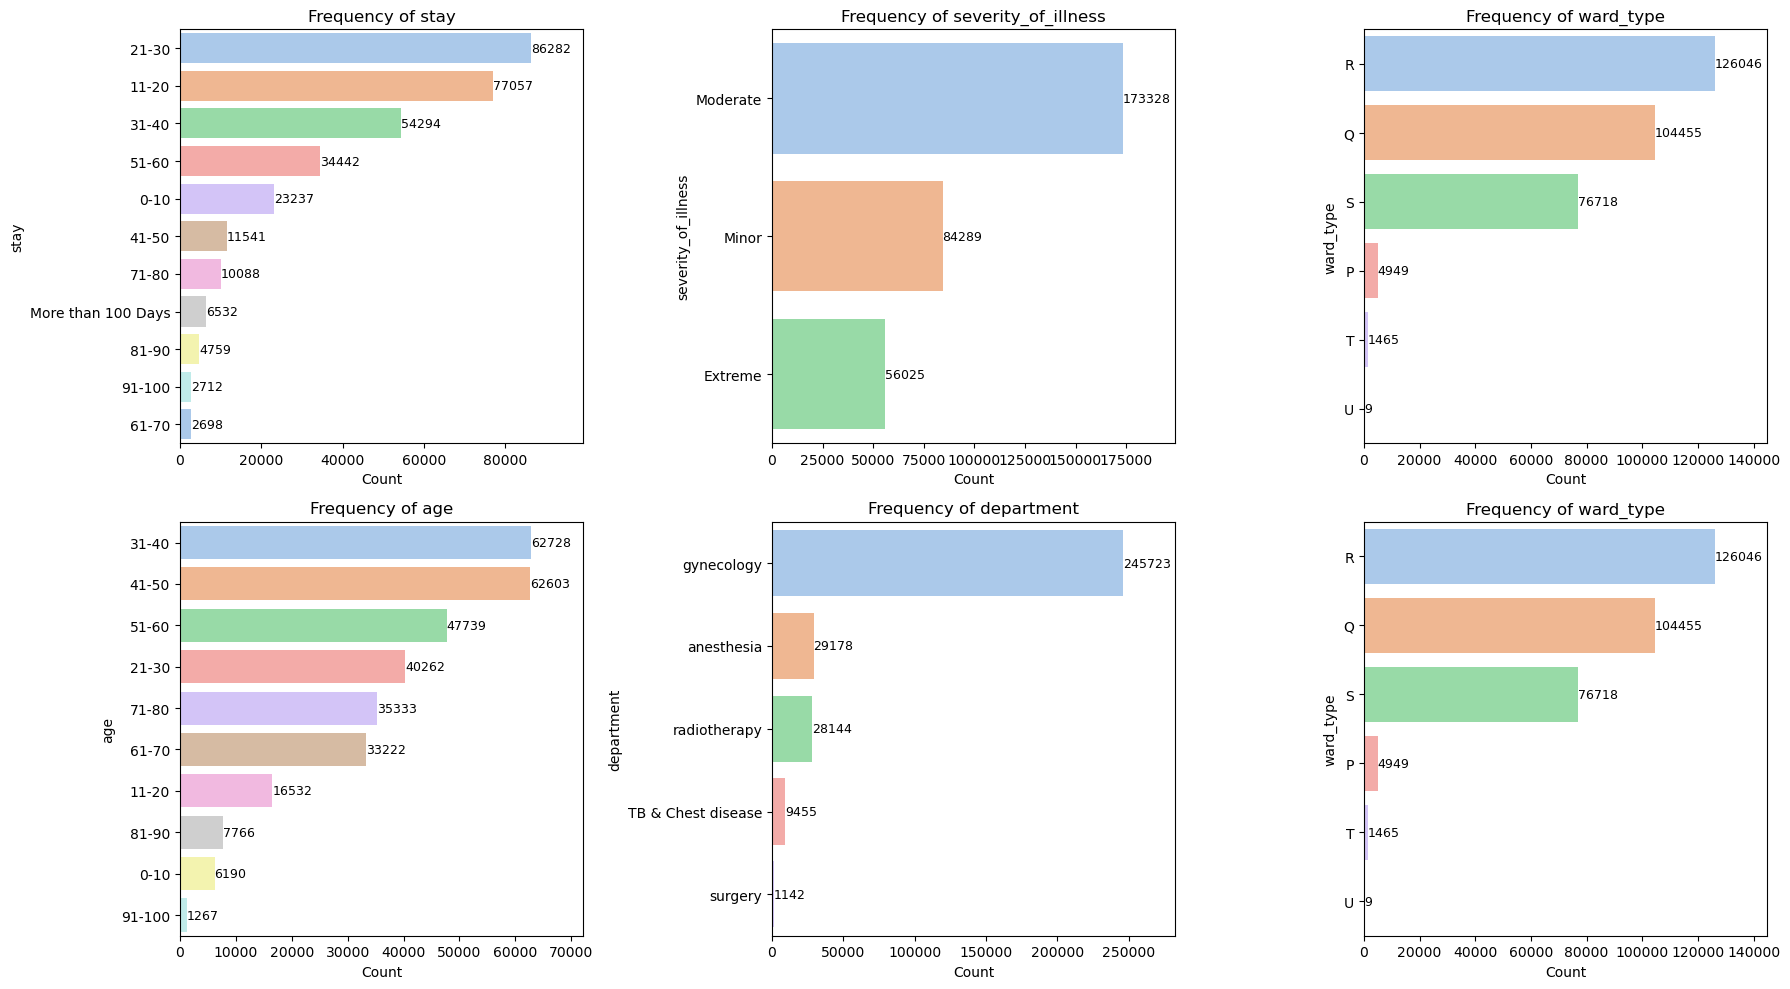

In [151]:
plot=['stay', 'severity_of_illness', 'ward_type', 'age', 'department', 'ward_type']

fn.plot_categorical_variables(df_Train,plot,orientation="horizontal")

In [152]:
fn.get_descriptions_for_variables(df_description,numerical_features)

,Column,Description
0,available_extra_rooms_in_hospital,Number of Extra rooms available in the Hospital
1,visitors_with_patient,Number of Visitors with the patient
2,admission_deposit,Deposit at the Admission Time


In [153]:
importlib.reload(fn)

<module 'customfunctions' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\customfunctions.py'>

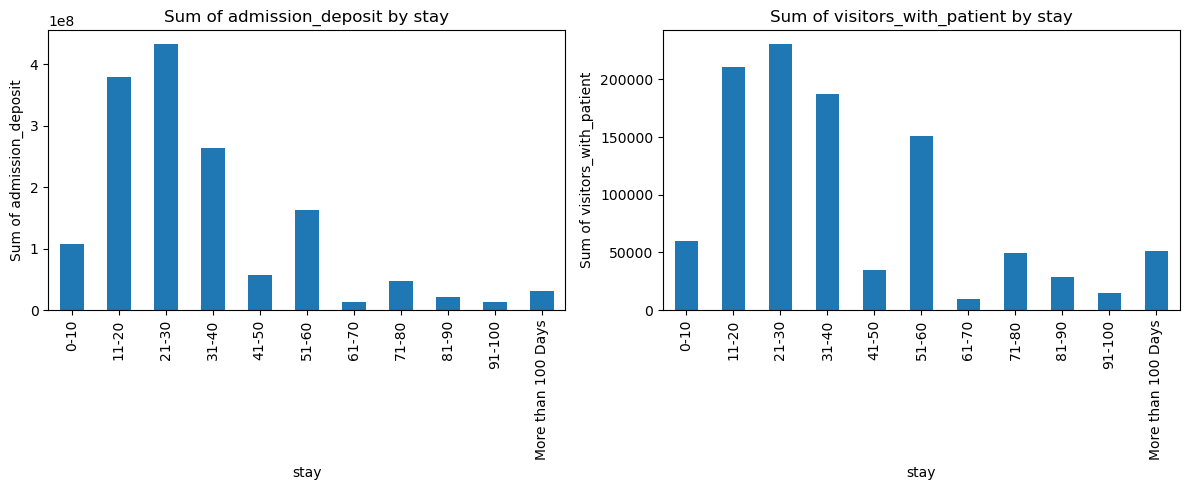

In [154]:
fn.groupby_combined_plots(
    data=df_Train,
    groupby_combinations=[["stay"]],
    agg_columns=["admission_deposit", "visitors_with_patient"],
    agg_func="sum",
    plot_kind="bar",
    stacked=False,
)





In [155]:
df_Train.nunique()

hospital_code                          32
hospital_type_code                      7
city_code_hospital                     11
hospital_region_code                    3
available_extra_rooms_in_hospital      18
department                              5
ward_type                               6
ward_facility_code                      6
bed_grade                               4
city_code_patient                      37
type_of_admission                       3
severity_of_illness                     3
visitors_with_patient                  28
age                                    10
admission_deposit                    7283
stay                                   11
dtype: int64

e:\myprojects\mlprojects\Healthcare - Length of Stay\Code\customfunctions.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(groupby_columns).size().reset_index(name="Count")
e:\myprojects\mlprojects\Healthcare - Length of Stay\Code\customfunctions.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(groupby_columns).size().reset_index(name="Count")


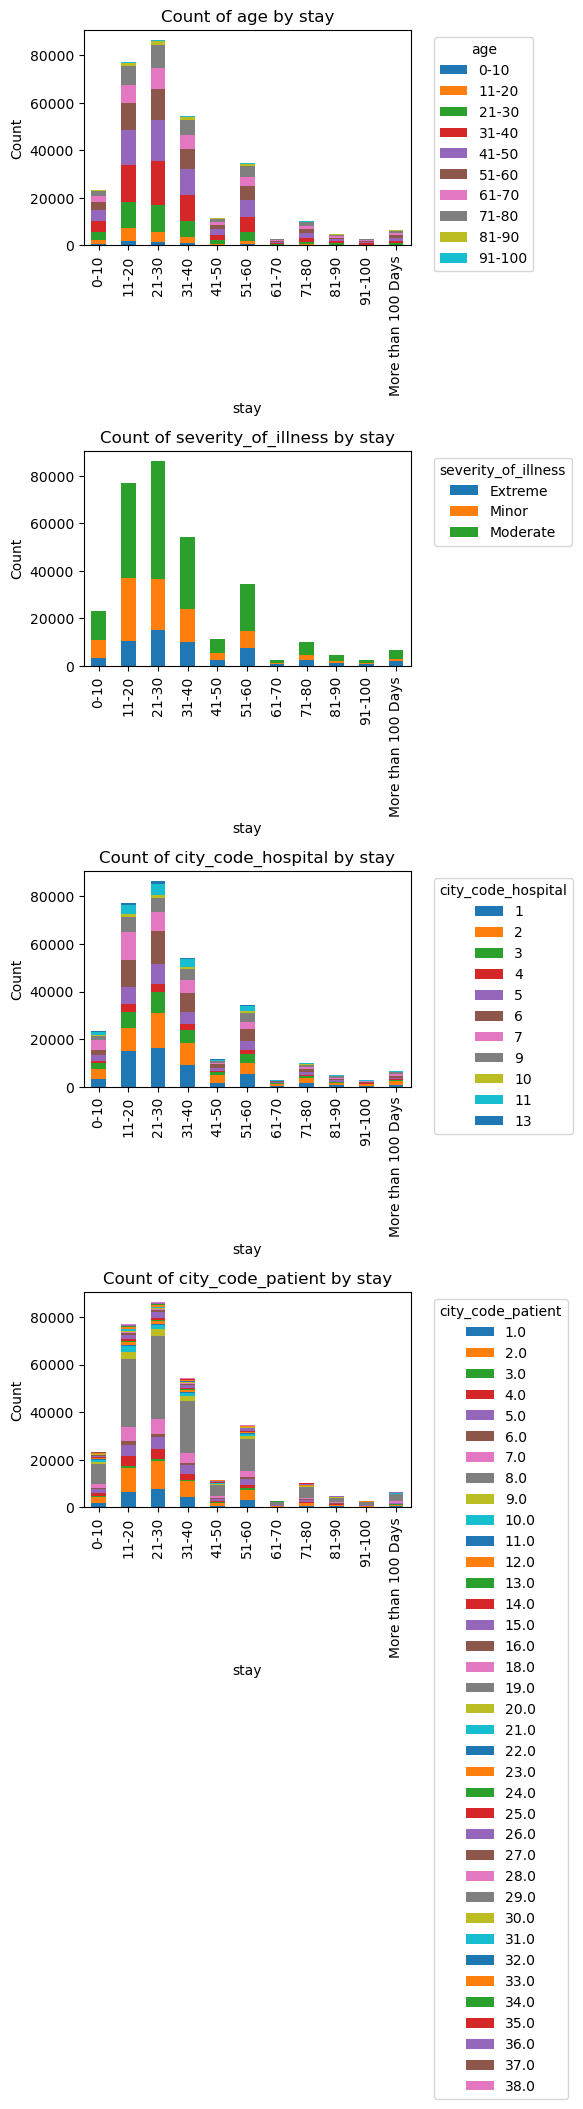

In [156]:
fn.groupby_combined_plots(
    data=df_Train,
    groupby_combinations=[['stay', 'age'], ['stay', 'severity_of_illness'], ['stay', 'city_code_hospital'], ['stay', 'city_code_patient']],

    agg_columns=None,  
    agg_func="count",
    plot_kind="bar",
    
    stacked=True,
)


In [157]:
importlib.reload(fn)

<module 'customfunctions' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\customfunctions.py'>

Stay and Admission Deposit

Stay durations of 21-30 days and 11-20 days have the highest frequencies and the largest admission deposits, indicating that these are the most common stay durations for patients.

Severity of Illness:

Most patients have a moderate severity illness, suggesting the hospitals primarily deals with manageable cases.
Cases with extreme severity are the least frequent, indicating a smaller proportion of critical patients.

Ward Type:

Ward Type R is the most utilized, followed by Ward Type Q.

Wards like T and U have minimal utilization, possibly indicating specialized or less frequent use.

Age Distribution:

The age group 41-50 and 31-40 are the most common.

Younger patients (0-10 years) and very elderly patients (91-100 years) are the least frequent, showing the hospitals caters predominantly to middle-aged patients.

Department:

Gynecology overwhelmingly dominates in patient numbers, indicating a focus on women’s health.
Departments like Anesthesia and Radiotherapy also have considerable caseloads, whereas TB & Chest Disease and Surgery handle relatively fewer cases.

Visitors with Patients:

For most stay ranges, the number of visitors generally aligns with the frequency of stays and admission deposits.
However, the 51-60 days range shows a unique pattern:
Despite having fewer patients and lower admission deposits, this range has a significant number of visitors.
This suggests that patients with longer hospital stays tend to attract more visitors, potentially due to the perceived severity of their condition or the emotional concern associated with prolonged hospitalization.

Age and Severity of Illness

Stay durations of 11-20 days and 21-30 days are the most common, primarily driven by patients aged 21-50 years. In contrast, younger patients (0-10 years) and elderly patients (91-100 years) have significantly fewer cases, highlighting a focus on middle-aged patient care during mid-length hospital stays.


Most hospital stays involve patients with moderate severity illnesses, particularly for durations of 11-20 days and 21-30 days. Minor severity cases are also common, though less frequent, while extreme severity cases are rare, indicating the hospitals primarily handles manageable conditions with mid-length stays.

In [158]:
fn.get_descriptions_for_variables(df_description,numerical_features)

,Column,Description
0,available_extra_rooms_in_hospital,Number of Extra rooms available in the Hospital
1,visitors_with_patient,Number of Visitors with the patient
2,admission_deposit,Deposit at the Admission Time


In [159]:
fn.get_descriptions_for_variables(df_description,categorical_features)

,Column,Description
0,hospital_code,Unique code for the Hospital
1,hospital_type_code,Unique code for the type of Hospital
2,city_code_hospital,City Code of the Hospital
3,hospital_region_code,Region Code of the Hospital
4,department,Department overlooking the case
5,ward_type,Code for the Ward type
6,ward_facility_code,Code for the Ward Facility
7,bed_grade,Condition of Bed in the Ward
8,city_code_patient,City Code for the patient
9,type_of_admission,Admission Type registered by the Hospital


## Encoding

In [160]:
import encoding as en

In [161]:
importlib.reload(en)

<module 'encoding' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\encoding.py'>

In [162]:
df_Train_1 = df_Train.copy()  # Make a copy of df_Train
df_Test_1 = df_Test.copy()    # Make a copy of df_Test
df_Train_2 = df_Train.copy()  # Make a copy of df_Train
df_Test_2 = df_Test.copy()    # Make a copy of df_Test


In [163]:
df_Train_1_encoded = en.encode_data(df_Train_1)


Encoding data...
Ordinal Encoding applied to 'severity_of_illness'
Ordinal Encoding applied to 'age'
Ordinal Encoding applied to 'type_of_admission'
Ordinal Encoding applied to 'stay'
One-Hot Encoding applied to: hospital_type_code, city_code_hospital, hospital_region_code, department, ward_type, ward_facility_code, bed_grade


In [164]:
df_Test_1_encoded = en.encode_data(df_Test_1)

Encoding data...
Ordinal Encoding applied to 'severity_of_illness'
Ordinal Encoding applied to 'age'
Ordinal Encoding applied to 'type_of_admission'
One-Hot Encoding applied to: hospital_type_code, city_code_hospital, hospital_region_code, department, ward_type, ward_facility_code, bed_grade


In [165]:
# Simple Target Encoding Example:
df_Train_1_encoded, encoding_mapping_1 = en.target_encode(df_Train_1_encoded,'city_code_patient', target_column='stay')


Simple Target Encoding applied to: city_code_patient based on target 'stay'


In [166]:
df_Test_1_encoded,_ = en.target_encode(df_Test_1_encoded, column='city_code_patient', encoding_mapping=encoding_mapping_1)




Simple Target Encoding applied to: city_code_patient using pre-learned mapping


In [167]:
df_Train_1_encoded, encoding_mapping_1 = en.target_encode(df_Train_1_encoded,'hospital_code' ,target_column='stay')

Simple Target Encoding applied to: hospital_code based on target 'stay'


In [168]:
df_Test_1_encoded,_ = en.target_encode(df_Test_1_encoded, column='hospital_code', encoding_mapping=encoding_mapping_1)

Simple Target Encoding applied to: hospital_code using pre-learned mapping


In [169]:
len(df_Train_1_encoded.columns)

64

In [170]:
len(df_Train_1.columns)

16

In [171]:
len(df_Test_1.columns)

15

In [172]:
len(df_Test_1_encoded.columns)

63

In [173]:
df_Train_1.isnull().sum()

hospital_code                        0
hospital_type_code                   0
city_code_hospital                   0
hospital_region_code                 0
available_extra_rooms_in_hospital    0
department                           0
ward_type                            0
ward_facility_code                   0
bed_grade                            0
city_code_patient                    0
type_of_admission                    0
severity_of_illness                  0
visitors_with_patient                0
age                                  0
admission_deposit                    0
stay                                 0
dtype: int64

In [174]:
df_Test_1_encoded.isnull().sum()

available_extra_rooms_in_hospital    0
type_of_admission                    0
severity_of_illness                  0
visitors_with_patient                0
age                                  0
admission_deposit                    0
hospital_type_code_b                 0
hospital_type_code_c                 0
hospital_type_code_d                 0
hospital_type_code_e                 0
hospital_type_code_f                 0
hospital_type_code_g                 0
city_code_hospital_2                 0
city_code_hospital_3                 0
city_code_hospital_4                 0
city_code_hospital_5                 0
city_code_hospital_6                 0
city_code_hospital_7                 0
city_code_hospital_9                 0
city_code_hospital_10                0
city_code_hospital_11                0
city_code_hospital_13                0
hospital_region_code_Y               0
hospital_region_code_Z               0
department_anesthesia                0
department_gynecology    

## Modelling

In [175]:
import sys
if 'modeling' in sys.modules:
    del sys.modules['modeling']

In [176]:
import modeling as m

In [177]:
from sklearn.model_selection import train_test_split

# Prepare the feature sets (encoded and non-encoded)
X_encoded = df_Train_1_encoded.drop(columns=["stay"])  # Drop target column from encoded features
X_not_encoded = df_Train_1.drop(columns=["stay"])      # Drop target column from non-encoded features

# The target variable remains the same for both encoded and non-encoded datasets
y = df_Train_1["stay"]  # Target column


# Split the encoded dataset
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=seed, stratify=y
)

# Split the non-encoded dataset
X_train_not_encoded, X_test_not_encoded, _, _ = train_test_split(
    X_not_encoded, y, test_size=0.2, random_state=seed, stratify=y
)


In [178]:
# Check if the indices in both splits match
train_encoded_indices = X_train_encoded.index
train_not_encoded_indices = X_train_not_encoded.index

test_encoded_indices = X_test_encoded.index
test_not_encoded_indices = X_test_not_encoded.index

print("Do training indices match?", train_encoded_indices.equals(train_not_encoded_indices))
print("Do testing indices match?", test_encoded_indices.equals(test_not_encoded_indices))

# Check class distribution in y_train and y_test
from collections import Counter

print("Class distribution in y_train:", Counter(y_train))
print("Class distribution in y_test:", Counter(y_test))


Do training indices match? True
Do testing indices match? True
Class distribution in y_train: Counter({3: 69025, 2: 61645, 4: 43435, 6: 27554, 1: 18590, 5: 9233, 8: 8070, 11: 5226, 9: 3807, 10: 2170, 7: 2158})
Class distribution in y_test: Counter({3: 17257, 2: 15412, 4: 10859, 6: 6888, 1: 4647, 5: 2308, 8: 2018, 11: 1306, 9: 952, 10: 542, 7: 540})


In [286]:
importlib.reload(m)

<module 'modeling' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\modeling.py'>

In [287]:
if isinstance(categorical_features, pd.Index):
    categorical_features = categorical_features.tolist()
if 'stay' in categorical_features:
    categorical_features.remove('stay')
    print("Removed 'stay' from categorical_columns.")

In [288]:
if isinstance(numerical_features, pd.Index):
    numerical_features =numerical_features.tolist()

In [289]:
   
cores, memory, gpu_available = m.check_system_resources()    
    # Define the models to evaluate
models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'LightGBM': lgb.LGBMClassifier(
            n_jobs=-1, 
            random_state=42, 
            device='gpu' if m.detect_device("LightGBM", gpu_available) == "GPU" else 'cpu',
            boosting_type='gbdt',
            categorical_feature=categorical_features  # Pass categorical columns
        ),
        'XGBoost': xgb.XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_jobs=-1,
            tree_method='gpu_hist' if m.detect_device("XGBoost", gpu_available) == "GPU" else 'auto'
        ),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'CatBoost': CatBoostClassifier(
            verbose=0, 
            random_state=42, 
            task_type='GPU' if m.detect_device("CatBoost", gpu_available) == "GPU" else 'CPU'
        ),
        'Logistic Regression': OneVsRestClassifier(
            LogisticRegression(
                solver='saga', max_iter=500, random_state=42, n_jobs=-1
            )
        ),
        'SVM': OneVsRestClassifier(
            LinearSVC(random_state=42, max_iter=5000)
        ),
    }

System has 28 CPU cores, 15.71 GB of RAM, and No GPU available.


In [290]:
len(X_train_encoded.columns)

63

In [291]:
# Now pass `models` to your `model_pipeline`
results_df, trained_models = m.model_pipeline(
    models=models,
    X_train_encoded=X_train_encoded,  # Replace with your actual training data
    X_test_encoded=X_test_encoded,
    X_train_non_encoded=X_train_not_encoded,
    X_test_non_encoded=X_test_not_encoded,
    y_train=y_train,
    y_test=y_test,
    numerical_columns=numerical_features,
    categorical_columns=categorical_features,
    prev_results_df=None  # Or replace with your existing results DataFrame
)

Function model_pipeline loaded successfully.
Models defined: ['Random Forest', 'LightGBM', 'XGBoost', 'Gradient Boosting', 'CatBoost', 'Logistic Regression', 'SVM']
System has 28 CPU cores, 15.71 GB of RAM, and No GPU available.

Starting Random Forest on CPU...
Estimated training time for Random Forest: ~15.81 seconds.
Actual training time for Random Forest: 14.99 seconds.
Finished Random Forest.


Starting LightGBM on CPU...
Using non-encoded dataset for LightGBM.
Estimated training time for LightGBM: ~7.90 seconds.


C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\lightgbm\basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\lightgbm\basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=hospital_code,hospital_type_code,city_code_hospital,hospital_region_code,department,ward_type,ward_facility_code,bed_grade,city_code_patient,type_of_admission,severity_of_illness,age, categorical_column=0,1,2,3,5,6,7,8,9,10,11,13 will be ignored. Current value: categorical_feature=hospital_code,hospital_type_code,city_code_hospital,hospital_region_code,department,ward_type,ward_facility_code,bed_grade,city_code_patient,type_of_admission,severity_of_illness,age
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 250913, number of used features: 15
[LightGBM] [Info] Start training from score -2.602482
[LightGBM] [Info] Start training from score -1.403714
[LightGBM] [Info] Start tr

C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [15:53:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Actual training time for XGBoost: 13.26 seconds.
Finished XGBoost.


Starting Gradient Boosting on CPU...
Estimated training time for Gradient Boosting: ~31.62 seconds.
Actual training time for Gradient Boosting: 1704.54 seconds.
Finished Gradient Boosting.


Starting CatBoost on CPU...
Using non-encoded dataset for CatBoost.
Estimated training time for CatBoost: ~15.81 seconds.
Actual training time for CatBoost: 5273.04 seconds.


C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finished CatBoost.


Starting Logistic Regression on CPU...
Estimated training time for Logistic Regression: ~0.79 seconds.


C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Actual training time for Logistic Regression: 1084.92 seconds.


C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finished Logistic Regression.


Starting SVM on CPU...
Estimated training time for SVM: ~158.08 seconds.
Actual training time for SVM: 146.31 seconds.


C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finished SVM.



In [292]:
# Print final results
results_df

,Model,Train Accuracy,Train Precision,Train Recall,Train F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test ROC AUC,Estimated Time (s),Actual Time (s)
0,Random Forest,0.9996,0.9996,0.9996,0.9996,0.3688,0.3522,0.3688,0.3554,0.7489,15.8075,14.9884
1,LightGBM,0.4547,0.4828,0.4547,0.4226,0.4269,0.4067,0.4269,0.3914,0.8069,7.9038,6.6490
2,XGBoost,0.4692,0.5022,0.4692,0.4400,0.4271,0.4136,0.4271,0.3928,0.8079,15.8075,13.2581
3,Gradient Boosting,0.4204,0.4384,0.4204,0.3790,0.4190,0.4104,0.4190,0.3761,0.7968,31.6150,1704.5416
4,CatBoost,0.4419,0.4504,0.4419,0.4064,0.4291,0.4106,0.4291,0.3922,0.8132,15.8075,5273.0416
5,Logistic Regression,0.3847,0.3477,0.3847,0.3318,0.3862,0.3502,0.3862,0.3329,0.7634,0.7904,1084.9159
6,SVM,0.3749,0.3380,0.3749,0.3080,0.3761,0.3366,0.3761,0.3083,NaN,158.0752,146.3064


In [293]:
trained_models

{'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=42),
 'LightGBM': LGBMClassifier(categorical_feature=['hospital_code', 'hospital_type_code',
                                     'city_code_hospital',
                                     'hospital_region_code', 'department',
                                     'ward_type', 'ward_facility_code',
                                     'bed_grade', 'city_code_patient',
                                     'type_of_admission', 'severity_of_illness',
                                     'age'],
                device='cpu', n_jobs=-1, random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None,

## Feature Selection

In [294]:
import Featureimportance as ft


In [295]:
importlib.reload(ft)

<module 'Featureimportance' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\Featureimportance.py'>

In [296]:
selected_trained_models = {
        "Gradient Boosting": trained_models["Gradient Boosting"],
        "XGBoost": trained_models["XGBoost"],
        "CatBoost": trained_models["CatBoost"],
        "LightGBM": trained_models["LightGBM"]
    }

encoded_importance_df, non_encoded_importance_df = ft.aggregate_feature_importance(
        models=selected_trained_models,
        X_train_encoded=X_train_encoded,
        X_train_non_encoded=X_train_not_encoded,
        selected_models=list(selected_trained_models.keys()))


Processing feature importance for: Gradient Boosting
Processing feature importance for: XGBoost
Processing feature importance for: CatBoost
Processing feature importance for: LightGBM
Encoded DataFrame processed. Total features: 63.
Non-Encoded DataFrame processed. Total features: 15.


In [297]:
encoded_importance_df

,Feature,Gradient Boosting,XGBoost,Average_Importance
52,visitors_with_patient,0.4991,0.1215,0.3103
58,ward_type_Q,0.1312,0.1591,0.1452
60,ward_type_S,0.0316,0.0744,0.0530
3,bed_grade_2.0,0.0400,0.0386,0.0393
51,type_of_admission,0.0400,0.0340,0.0370
34,hospital_code_2_prob,0.0385,0.0327,0.0356
2,available_extra_rooms_in_hospital,0.0366,0.0144,0.0255
0,admission_deposit,0.0374,0.0108,0.0241
50,severity_of_illness,0.0266,0.0189,0.0227
59,ward_type_R,0.0133,0.0283,0.0208


In [298]:
non_encoded_importance_df

,Feature,CatBoost,LightGBM,Average_Importance
12,visitors_with_patient,0.2913,0.1167,0.2040
0,admission_deposit,0.0666,0.2319,0.1493
7,hospital_code,0.0777,0.1918,0.1347
5,city_code_patient,0.0742,0.1298,0.1020
14,ward_type,0.1503,0.0372,0.0938
2,available_extra_rooms_in_hospital,0.0363,0.0694,0.0528
1,age,0.0472,0.0545,0.0509
11,type_of_admission,0.0497,0.0485,0.0491
10,severity_of_illness,0.0326,0.0498,0.0412
3,bed_grade,0.0535,0.0236,0.0385


In [299]:
# Extract features for Gradient Boosting and XGBoost with threshold >= 0.01
gb_features = encoded_importance_df.loc[
    encoded_importance_df["Gradient Boosting"] >= 0.01, "Feature"
].tolist()

xgb_features = encoded_importance_df.loc[
    encoded_importance_df["XGBoost"] >= 0.01, "Feature"
].tolist()

# Extract features for CatBoost and LightGBM with threshold >= 0.01
catboost_features = non_encoded_importance_df.loc[
    non_encoded_importance_df["CatBoost"] >= 0.01, "Feature"
].tolist()

lightgbm_features = non_encoded_importance_df.loc[
    non_encoded_importance_df["LightGBM"] >= 0.01, "Feature"
].tolist()

# Display the selected features
print("Selected features for Gradient Boosting:", gb_features)
print("Selected features for XGBoost:", xgb_features)
print("Selected features for CatBoost:", catboost_features)
print("Selected features for LightGBM:", lightgbm_features)


Selected features for Gradient Boosting: ['visitors_with_patient', 'ward_type_Q', 'ward_type_S', 'bed_grade_2.0', 'type_of_admission', 'hospital_code_2_prob', 'available_extra_rooms_in_hospital', 'admission_deposit', 'severity_of_illness', 'ward_type_R', 'hospital_code_5_prob']
Selected features for XGBoost: ['visitors_with_patient', 'ward_type_Q', 'ward_type_S', 'bed_grade_2.0', 'type_of_admission', 'hospital_code_2_prob', 'available_extra_rooms_in_hospital', 'admission_deposit', 'severity_of_illness', 'ward_type_R', 'hospital_code_5_prob', 'hospital_code_1_prob', 'city_code_patient_2_prob', 'hospital_code_3_prob', 'city_code_patient_11_prob', 'hospital_code_7_prob', 'bed_grade_3.0', 'department_anesthesia', 'city_code_patient_1_prob', 'city_code_patient_10_prob', 'hospital_type_code_b', 'hospital_code_8_prob', 'bed_grade_4.0', 'department_gynecology', 'hospital_code_10_prob', 'city_code_hospital_7', 'city_code_hospital_11']
Selected features for CatBoost: ['visitors_with_patient', 'a

### Retraining

In [300]:
importlib.reload(m)

<module 'modeling' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\modeling.py'>

In [301]:
selected_models = {
    "Gradient Boosting": models["Gradient Boosting"],
    "XGBoost": models["XGBoost"],
    "CatBoost": models["CatBoost"],
    "LightGBM": models["LightGBM"],
}

# Define feature sets for each model using the extracted features
feature_sets = {
    "Gradient Boosting": gb_features,
    "XGBoost": xgb_features,
    "CatBoost": catboost_features,
    "LightGBM": lightgbm_features
}

In [309]:
# Initialize dictionaries to store retrained models and results
retrained_models = {}
all_results = []

# Loop through each selected model and its respective features
for model_name, model in selected_models.items():
    print(f"\nTraining and evaluating {model_name} with selected features...")

    # Get the feature subset for the current model
    selected_features = feature_sets[model_name]

    # Initialize filtered datasets
    X_train_encoded_filtered, X_test_encoded_filtered = X_train_encoded.copy(), X_test_encoded.copy()
    X_train_not_encoded_filtered, X_test_not_encoded_filtered = X_train_not_encoded.copy(), X_test_not_encoded.copy()

    # Dynamically filter numerical and categorical columns
    filtered_categorical_columns = [col for col in categorical_features if col in selected_features]
    filtered_numerical_columns = [col for col in numerical_features if col in selected_features]

    if model_name in ["LightGBM", "CatBoost"]:
        # Use non-encoded data for LightGBM and CatBoost
        X_train_not_encoded_filtered = X_train_not_encoded_filtered[selected_features]
        X_test_not_encoded_filtered = X_test_not_encoded_filtered[selected_features]
    else:
        # Use encoded data for other models
        X_train_encoded_filtered = X_train_encoded_filtered[selected_features]
        X_test_encoded_filtered = X_test_encoded_filtered[selected_features]

    # Call model_pipeline to train and evaluate the model
    results_df_retrained, re_trained_models = m.model_pipeline(
        models={model_name: model},  # Pass only the current model
        X_train_encoded=X_train_encoded_filtered,
        X_test_encoded=X_test_encoded_filtered,
        X_train_non_encoded=X_train_not_encoded_filtered,
        X_test_non_encoded=X_test_not_encoded_filtered,
        y_train=y_train,
        y_test=y_test,
        numerical_columns=filtered_numerical_columns,
        categorical_columns=filtered_categorical_columns if model_name in ["LightGBM", "CatBoost"] else [],
        prev_results_df=None  # No previous results for individual runs
    )

    # Store the results and trained models
    all_results.append(results_df_retrained)
    retrained_models.update(re_trained_models)  # Add the trained model to the dictionary

# Combine all results into a single DataFrame for comparison
retrained_results = pd.concat(all_results, axis=0, ignore_index=True)





Training and evaluating Gradient Boosting with selected features...
Function model_pipeline loaded successfully.
Models defined: ['Gradient Boosting']
System has 28 CPU cores, 15.71 GB of RAM, and No GPU available.

Starting Gradient Boosting on CPU...
Estimated training time for Gradient Boosting: ~5.52 seconds.
Actual training time for Gradient Boosting: 248.39 seconds.
Finished Gradient Boosting.


Training and evaluating XGBoost with selected features...
Function model_pipeline loaded successfully.
Models defined: ['XGBoost']
System has 28 CPU cores, 15.71 GB of RAM, and No GPU available.

Starting XGBoost on CPU...
Estimated training time for XGBoost: ~6.77 seconds.


C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [18:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Actual training time for XGBoost: 10.50 seconds.
Finished XGBoost.


Training and evaluating CatBoost with selected features...
Function model_pipeline loaded successfully.
Models defined: ['CatBoost']
System has 28 CPU cores, 15.71 GB of RAM, and No GPU available.

Starting CatBoost on CPU...
Using non-encoded dataset for CatBoost.
Estimated training time for CatBoost: ~15.81 seconds.
Actual training time for CatBoost: 6928.17 seconds.


C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finished CatBoost.


Training and evaluating LightGBM with selected features...
Function model_pipeline loaded successfully.
Models defined: ['LightGBM']
System has 28 CPU cores, 15.71 GB of RAM, and No GPU available.

Starting LightGBM on CPU...
Using non-encoded dataset for LightGBM.
Estimated training time for LightGBM: ~7.90 seconds.


C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\lightgbm\basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\Jermiah Jerome\AppData\Roaming\Python\Python312\site-packages\lightgbm\basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=hospital_code,hospital_type_code,city_code_hospital,hospital_region_code,department,ward_type,ward_facility_code,bed_grade,city_code_patient,type_of_admission,severity_of_illness,age, categorical_column=2,3,4,6,7,8,9,10,11 will be ignored. Current value: categorical_feature=hospital_code,hospital_type_code,city_code_hospital,hospital_region_code,department,ward_type,ward_facility_code,bed_grade,city_code_patient,type_of_admission,severity_of_illness,age
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 405
[LightGBM] [Info] Number of data points in the train set: 250913, number of used features: 12
[LightGBM] [Info] Start training from score -2.602482
[LightGBM] [Info] Start training from score -1.403714
[LightGBM] [Info] Start training 

In [310]:
# Display the final results
print("\nFinal Training and Evaluation Results:")
retrained_results


Final Training and Evaluation Results:


,Model,Train Accuracy,Train Precision,Train Recall,Train F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test ROC AUC,Estimated Time (s),Actual Time (s)
0,Gradient Boosting,0.4117,0.4304,0.4117,0.3700,0.4089,0.3859,0.4089,0.3659,0.7880,5.5201,248.3872
1,XGBoost,0.4622,0.4933,0.4622,0.4321,0.4262,0.4079,0.4262,0.3915,0.8055,6.7747,10.5022
2,CatBoost,0.4421,0.4495,0.4421,0.4067,0.4297,0.4079,0.4297,0.3927,0.8125,15.8075,6928.1725
3,LightGBM,0.4539,0.4827,0.4539,0.4217,0.4266,0.4085,0.4266,0.3913,0.8067,7.9038,4.4884


In [311]:
results_df

,Model,Train Accuracy,Train Precision,Train Recall,Train F1 Score,Test Accuracy,Test Precision,Test Recall,Test F1 Score,Test ROC AUC,Estimated Time (s),Actual Time (s)
0,Random Forest,0.9996,0.9996,0.9996,0.9996,0.3688,0.3522,0.3688,0.3554,0.7489,15.8075,14.9884
1,LightGBM,0.4547,0.4828,0.4547,0.4226,0.4269,0.4067,0.4269,0.3914,0.8069,7.9038,6.6490
2,XGBoost,0.4692,0.5022,0.4692,0.4400,0.4271,0.4136,0.4271,0.3928,0.8079,15.8075,13.2581
3,Gradient Boosting,0.4204,0.4384,0.4204,0.3790,0.4190,0.4104,0.4190,0.3761,0.7968,31.6150,1704.5416
4,CatBoost,0.4419,0.4504,0.4419,0.4064,0.4291,0.4106,0.4291,0.3922,0.8132,15.8075,5273.0416
5,Logistic Regression,0.3847,0.3477,0.3847,0.3318,0.3862,0.3502,0.3862,0.3329,0.7634,0.7904,1084.9159
6,SVM,0.3749,0.3380,0.3749,0.3080,0.3761,0.3366,0.3761,0.3083,NaN,158.0752,146.3064


In [312]:
retrained_models

{'Gradient Boosting': GradientBoostingClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x29c06c2cb00>,
 'LightGBM': LGBMClassifier(categorical_feature=['hospital_code', 'hospit

In [313]:
importlib.reload(m)

<module 'modeling' from 'e:\\myprojects\\mlprojects\\Healthcare - Length of Stay\\Code\\modeling.py'>

In [314]:
# Save trained models
m.save_models(trained_models, prefix="trained_")

# Save retrained models
m.save_models(retrained_models, prefix="retrained_")


Saved trained_Random Forest model to disk.
Saved trained_LightGBM model to disk.
Saved trained_XGBoost model to disk.
Saved trained_Gradient Boosting model to disk.
Saved trained_CatBoost model to disk.
Saved trained_Logistic Regression model to disk.
Saved trained_SVM model to disk.
Saved retrained_Gradient Boosting model to disk.
Saved retrained_XGBoost model to disk.
Saved retrained_CatBoost model to disk.
Saved retrained_LightGBM model to disk.


In [315]:
import json

# Save feature sets
with open("feature_sets.json", "w") as f:
    json.dump(feature_sets, f)
    print("Saved feature sets to disk.")

# Save results DataFrame
retrained_results.to_csv("retrained_results.csv", index=False)
print("Saved final results to disk.")


Saved feature sets to disk.
Saved final results to disk.


In [8]:
import joblib

# Replace 'model_filename.pkl' with the path to your saved model file
model = joblib.load('../Saved Models/retrained_CatBoost_model.pkl')

## Tuning under development

The tuning code below is currently under development and testing. We are working to identify the most efficient and optimal approach. Please refrain from referring to or relying on the code in this section until it is finalized.

In [88]:
import sys
if 'tuning' in sys.modules:
    del sys.modules['tuning']

In [ ]:
import tuning as tn

In [ ]:
importlib.reload(tn)

<module 'tuning' from 'g:\\Other computers\\Mac book emlyon\\emlyon\\principles & elementary models\\individual project\\HealthCare_LOS_Case\\codes\\tuning.py'>

In [ ]:
import optuna
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import time


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Number of folds for cross-validation
folds = 5  # You can modify this to increase or decrease cross-validation folds

# Create Optuna studies and optimize
catboost_study = optuna.create_study(direction="maximize")
catboost_study.optimize(lambda trial: objective_catboost(trial, X, y, folds=folds), n_trials=50)

lightgbm_study = optuna.create_study(direction="maximize")
lightgbm_study.optimize(lambda trial: objective_lightgbm(trial, X, y, folds=folds), n_trials=50)

xgboost_study = optuna.create_study(direction="maximize")
xgboost_study.optimize(lambda trial: objective_xgboost(trial, X, y, folds=folds), n_trials=50)

# Print the best hyperparameters
print("CatBoost Best ROC AUC:", catboost_study.best_value)
print("CatBoost Best Params:", catboost_study.best_params)

print("LightGBM Best ROC AUC:", lightgbm_study.best_value)
print("LightGBM Best Params:", lightgbm_study.best_params)

print("XGBoost Best ROC AUC:", xgboost_study.best_value)
print("XGBoost Best Params:", xgboost_study.best_params)

# Train models with the best parameters and collect metrics
metrics_summary = []

# CatBoost
start_time = time.time()
catboost_model = CatBoostClassifier(**catboost_study.best_params, verbose=0)
catboost_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time
y_pred_train = catboost_model.predict(X_train)
y_pred_test = catboost_model.predict(X_test)
y_pred_prob_test = catboost_model.predict_proba(X_test)

metrics_summary.append({
    "Model": "CatBoost",
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Train Precision": precision_score(y_train, y_pred_train, average="weighted"),
    "Train Recall": recall_score(y_train, y_pred_train, average="weighted"),
    "Train F1 Score": f1_score(y_train, y_pred_train, average="weighted"),
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, average="weighted"),
    "Test Recall": recall_score(y_test, y_pred_test, average="weighted"),
    "Test F1 Score": f1_score(y_test, y_pred_test, average="weighted"),
    "Test ROC AUC": roc_auc_score(y_test, y_pred_prob_test, multi_class="ovr"),
    "Time Taken (s)": elapsed_time,
})
joblib.dump(catboost_model, "catboost_model.pkl")

# LightGBM
start_time = time.time()
lightgbm_model = LGBMClassifier(**lightgbm_study.best_params)
lightgbm_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time
y_pred_train = lightgbm_model.predict(X_train)
y_pred_test = lightgbm_model.predict(X_test)
y_pred_prob_test = lightgbm_model.predict_proba(X_test)

metrics_summary.append({
    "Model": "LightGBM",
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Train Precision": precision_score(y_train, y_pred_train, average="weighted"),
    "Train Recall": recall_score(y_train, y_pred_train, average="weighted"),
    "Train F1 Score": f1_score(y_train, y_pred_train, average="weighted"),
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, average="weighted"),
    "Test Recall": recall_score(y_test, y_pred_test, average="weighted"),
    "Test F1 Score": f1_score(y_test, y_pred_test, average="weighted"),
    "Test ROC AUC": roc_auc_score(y_test, y_pred_prob_test, multi_class="ovr"),
    "Time Taken (s)": elapsed_time,
})
joblib.dump(lightgbm_model, "lightgbm_model.pkl")

# XGBoost
start_time = time.time()
xgboost_model = XGBClassifier(**xgboost_study.best_params, use_label_encoder=False)
xgboost_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time
y_pred_train = xgboost_model.predict(X_train)
y_pred_test = xgboost_model.predict(X_test)
y_pred_prob_test = xgboost_model.predict_proba(X_test)

metrics_summary.append({
    "Model": "XGBoost",
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Train Precision": precision_score(y_train, y_pred_train, average="weighted"),
    "Train Recall": recall_score(y_train, y_pred_train, average="weighted"),
    "Train F1 Score": f1_score(y_train, y_pred_train, average="weighted"),
    "Test Accuracy": accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, average="weighted"),
    "Test Recall": recall_score(y_test, y_pred_test, average="weighted"),
    "Test F1 Score": f1_score(y_test, y_pred_test, average="weighted"),
    "Test ROC AUC": roc_auc_score(y_test, y_pred_prob_test, multi_class="ovr"),
    "Time Taken (s)": elapsed_time,
})
joblib.dump(xgboost_model, "xgboost_model.pkl")

# Convert metrics_summary to DataFrame
metrics_df = pd.DataFrame(metrics_summary)




In [ ]:
# Display the metrics DataFrame
print(metrics_df)

In [ ]:

# Create Optuna studies and optimize
optuna_results = {}

for model_name, objective_func in [("CatBoost", objective_catboost),
                                   ("LightGBM", objective_lightgbm),
                                   ("XGBoost", objective_xgboost)]:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective_func(trial, X_train, X_test, y_train, y_test), n_trials=20)

    # Save the best parameters and metrics
    optuna_results[model_name] = {
        "best_params": study.best_params,
        "best_value": study.best_value,
        "elapsed_time": study.trials_dataframe()["datetime_complete"].max()
    }

# Print results and save models later
for model_name, result in optuna_results.items():
    print(f"\n{model_name} Best ROC AUC: {result['best_value']}")
    print(f"{model_name} Best Params: {result['best_params']}")
    print(f"{model_name} Total Optimization Time: {result['elapsed_time']}")

# Example: Saving the models outside the tuning code
catboost_model = CatBoostClassifier(**optuna_results["CatBoost"]["best_params"], verbose=0)
catboost_model.fit(X_train, y_train)
catboost_model.save_model("catboost_model.cbm")

lightgbm_model = LGBMClassifier(**optuna_results["LightGBM"]["best_params"])
lightgbm_model.fit(X_train, y_train)
joblib.dump(lightgbm_model, "lightgbm_model.pkl")

xgboost_model = XGBClassifier(**optuna_results["XGBoost"]["best_params"], use_label_encoder=False)
xgboost_model.fit(X_train, y_train)
joblib.dump(xgboost_model, "xgboost_model.pkl")
